# DataSynthesizer Usage (correlated attribute mode)

> This is a quick demo to use DataSynthesizer in correlated attribute mode.

### Step 1 import packages

In [8]:
from time import time

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import pandas as pd

### Step 2 user-defined parameteres

In [15]:
# input dataset
input_data = './data/100k_20features-10cls.csv'
na_values = {}
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f'./out/{mode}/description-synth-100k_20features-10cls.json'
synthetic_data = f'./out/{mode}/sythetic_data-synth-100k_20features-10cls.csv'

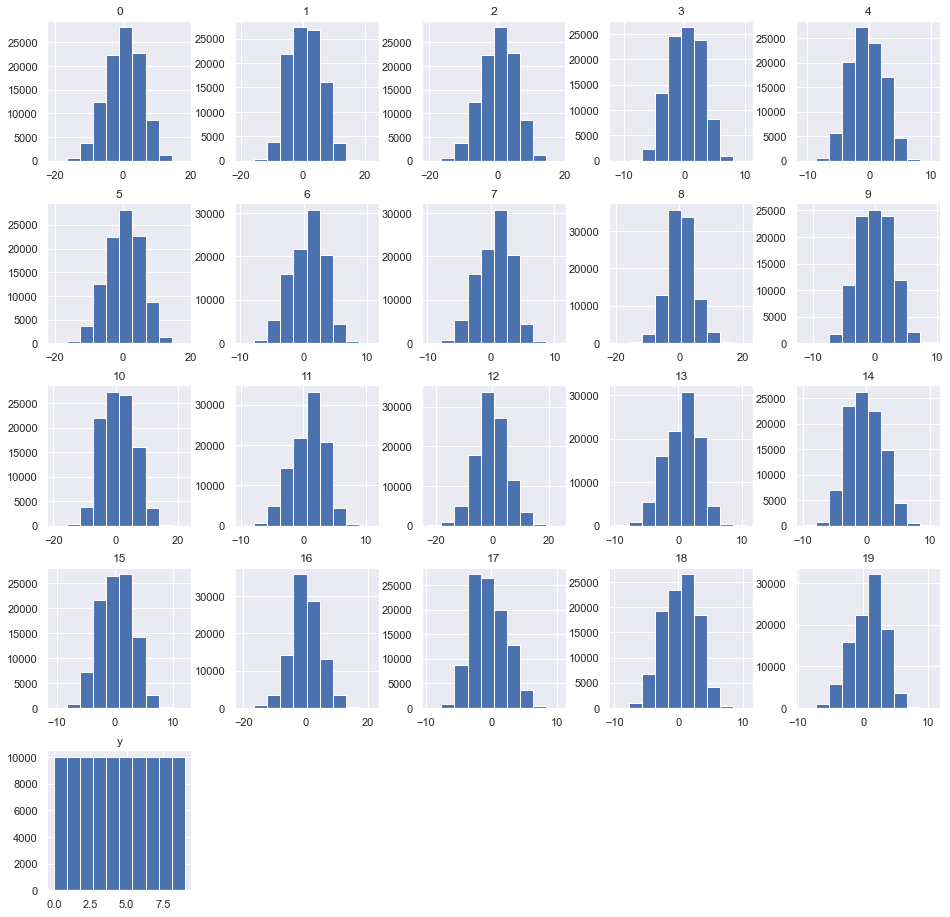

In [16]:
input_df = pd.read_csv(input_data, skipinitialspace=True, na_values=na_values)
input_df.columns
input_df.hist(figsize=(16,16))
cols_dict = {col: False for col in input_df.columns}


Default values set here, change here if needed.

In [17]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# specify categorical attributes
categorical_attributes = {}  # {'native-country': True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = cols_dict # {'index': True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = int(1e5) # Here 32561 is the same as input dataset, but it can be set to another number.

### Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [18]:
start = time()
describer = DataDescriber(category_threshold=threshold_value, null_values=na_values)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT 1
Adding attribute 10
Adding attribute 9
Adding attribute y
Adding attribute 12
Adding attribute 2
Adding attribute 5
Adding attribute 0
Adding attribute 17
Adding attribute 19
Adding attribute 16
Adding attribute 14
Adding attribute 18
Adding attribute 15
Adding attribute 3
Adding attribute 8
Adding attribute 7
Adding attribute 13
Adding attribute 6
Adding attribute 4
Adding attribute 11
========================== BN constructed ==========================


In [19]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    10 has parents ['1'].
    9  has parents ['10', '1'].
    y  has parents ['9', '1'].
    12 has parents ['y', '1'].
    2  has parents ['12', 'y'].
    5  has parents ['2', '9'].
    0  has parents ['5', '1'].
    17 has parents ['2', 'y'].
    19 has parents ['2', '10'].
    16 has parents ['12', '10'].
    14 has parents ['0', '12'].
    18 has parents ['5', 'y'].
    15 has parents ['16', '1'].
    3  has parents ['0', '1'].
    8  has parents ['0', 'y'].
    7  has parents ['16', 'y'].
    13 has parents ['7', '8'].
    6  has parents ['7', '10'].
    4  has parents ['12', 'y'].
    11 has parents ['14', 'y'].


### Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [20]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)
print('took {} seconds'.format(time() - start))

took 1270.1730260849 seconds


### Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

#### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [8]:
# Read both datasets using Pandas.
input_df = pd.read_csv(input_data, skipinitialspace=True, na_values=na_values)
synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

#### 5.2 compare histograms between input and synthetic datasets.

/Users/cl/Documents/projects/privbayes/DataSynthesizer/ModelInspector.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 5), dpi=120)


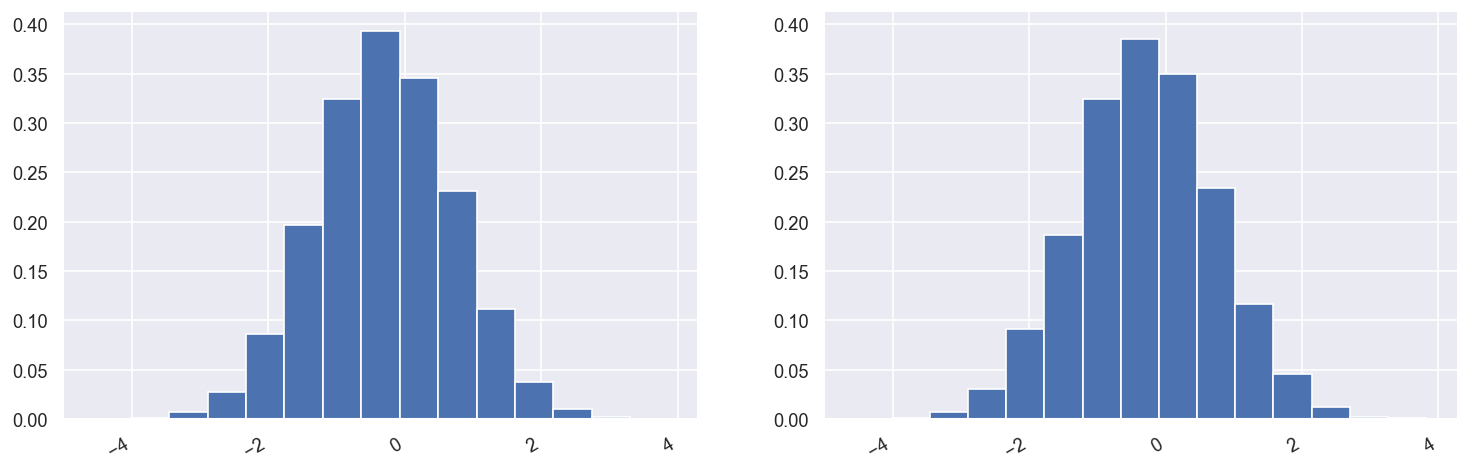

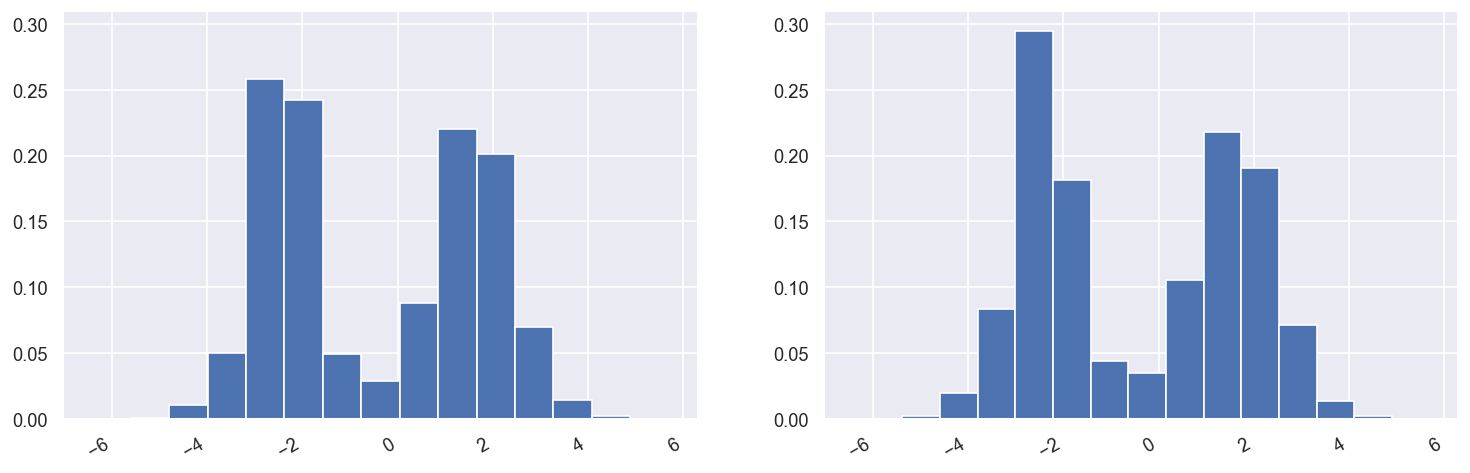

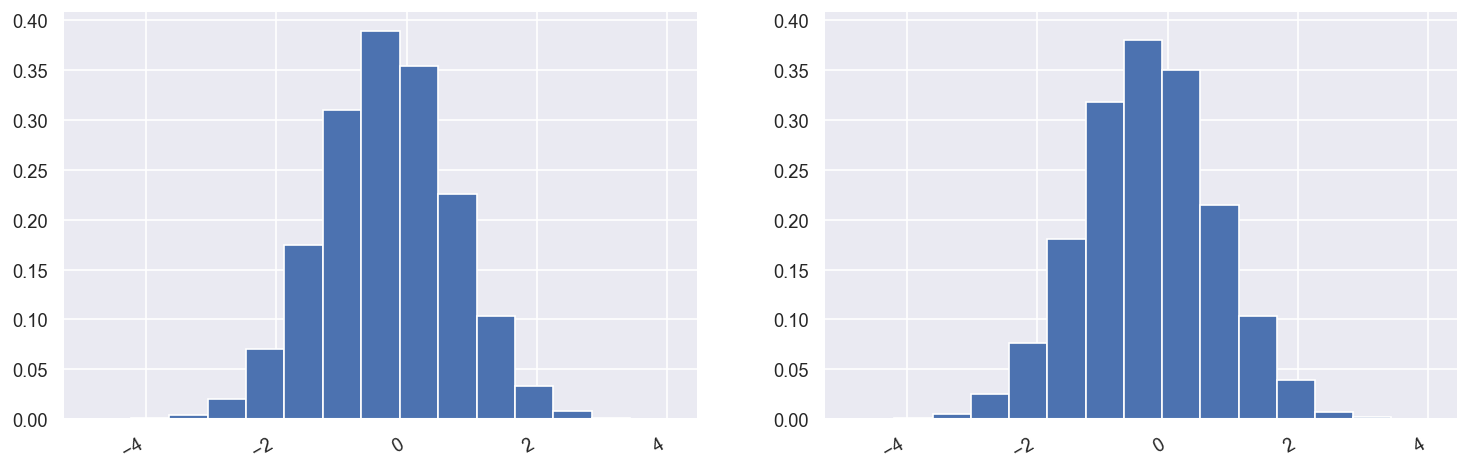

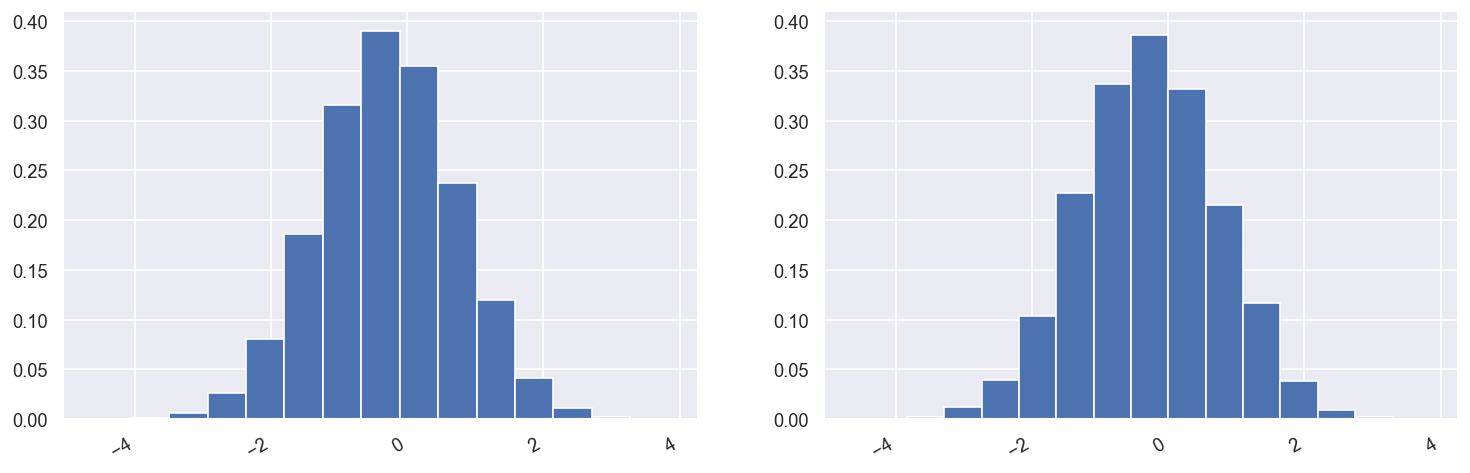

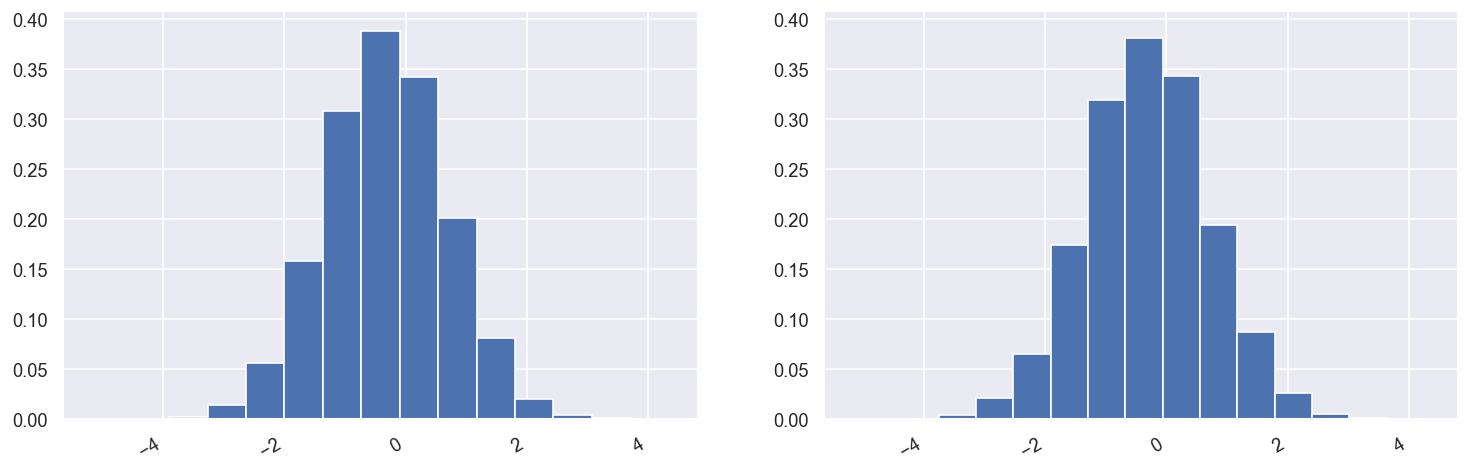

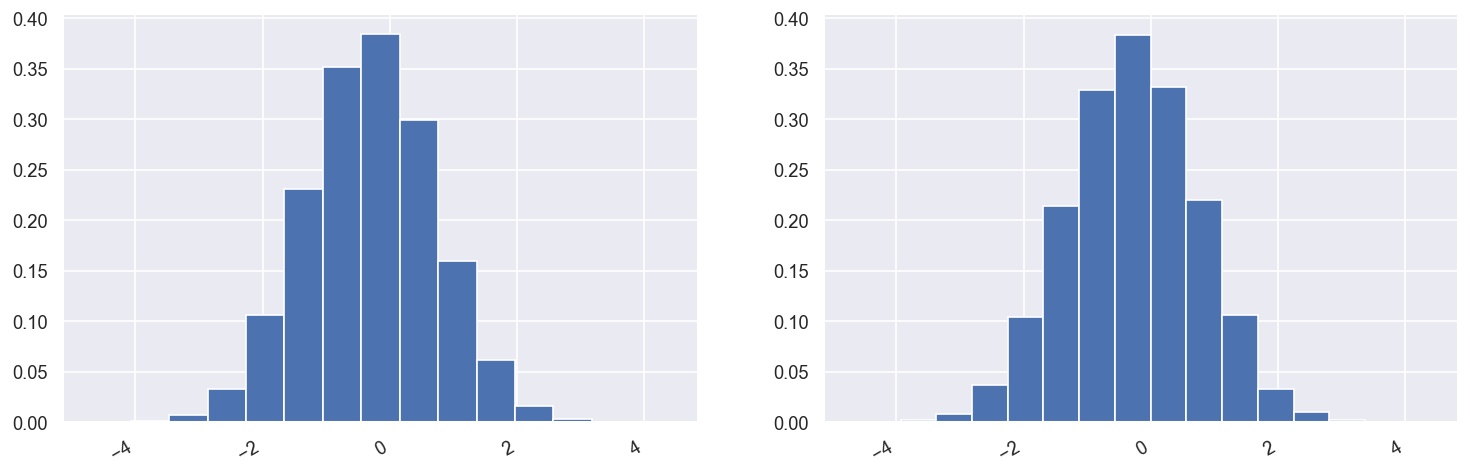

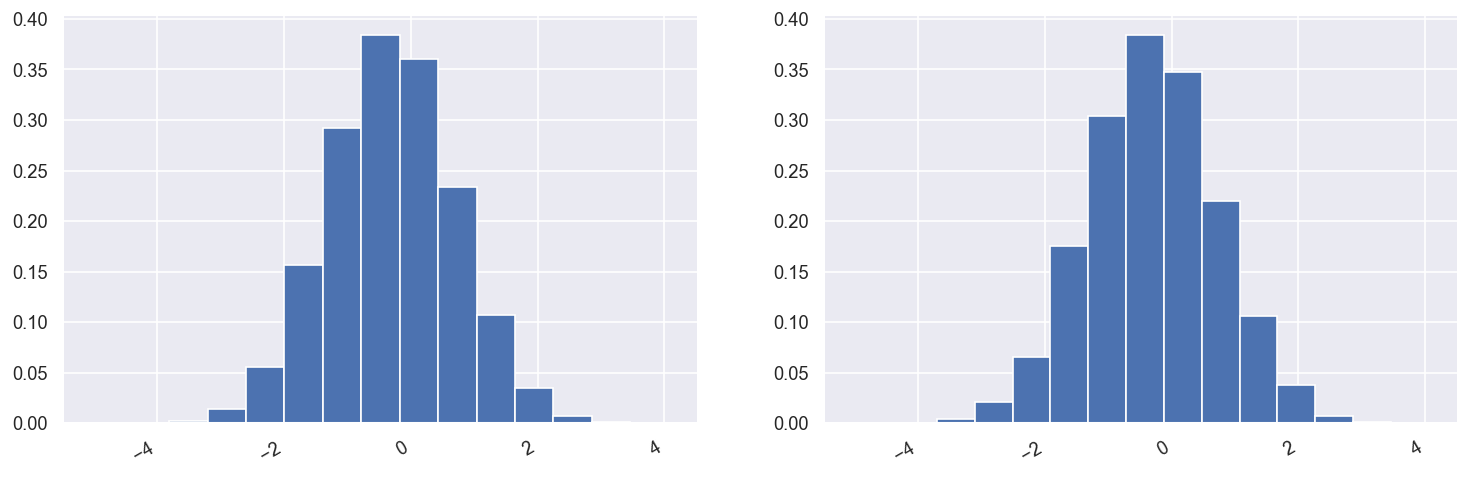

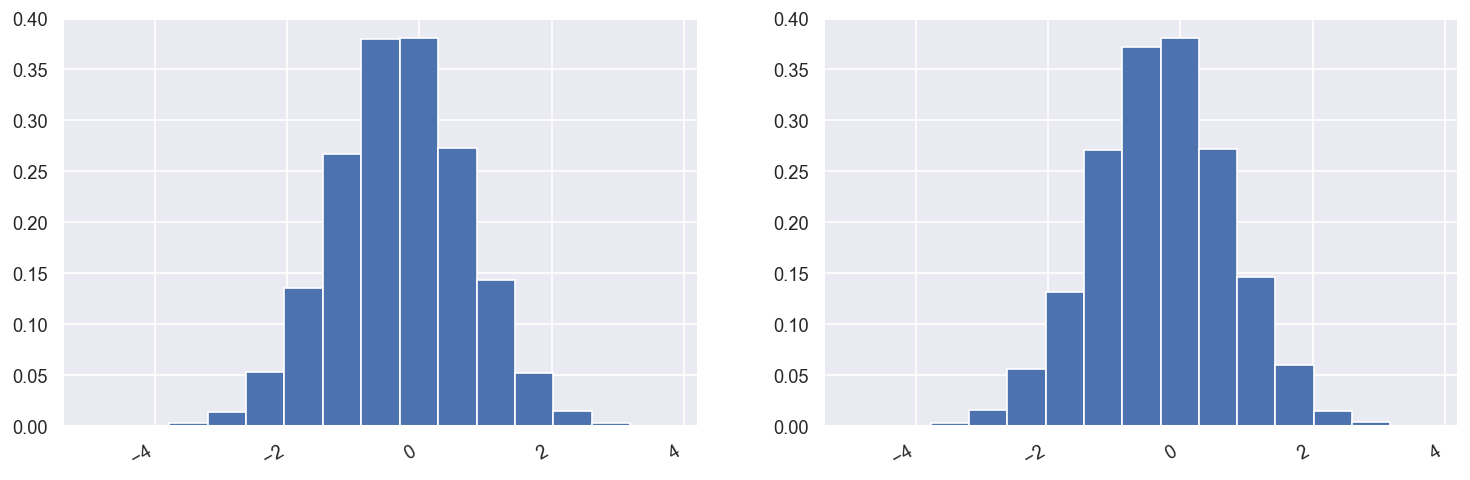

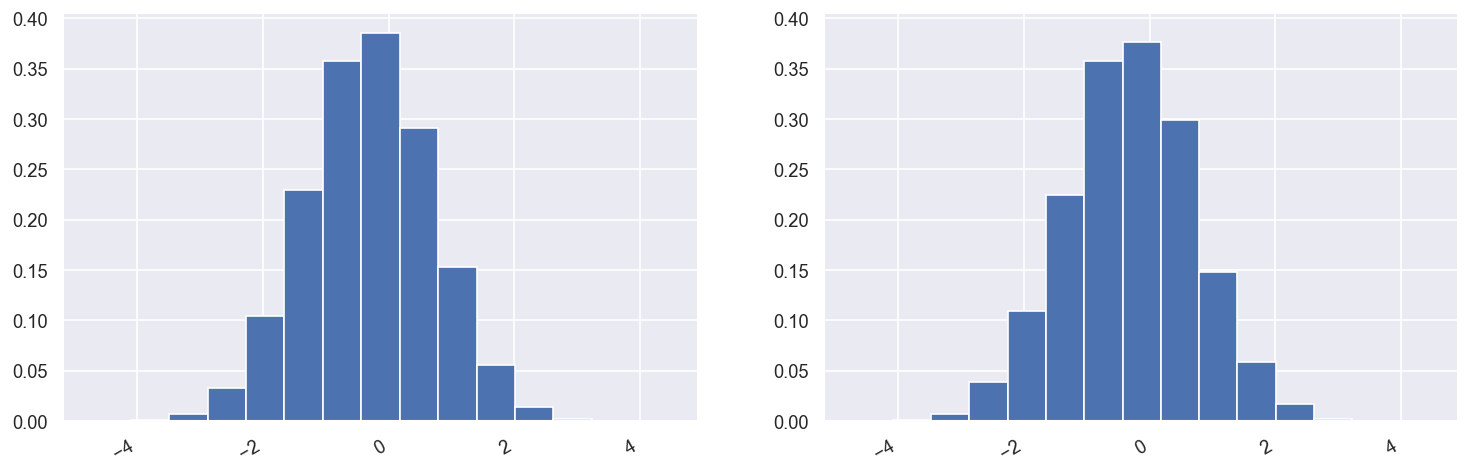

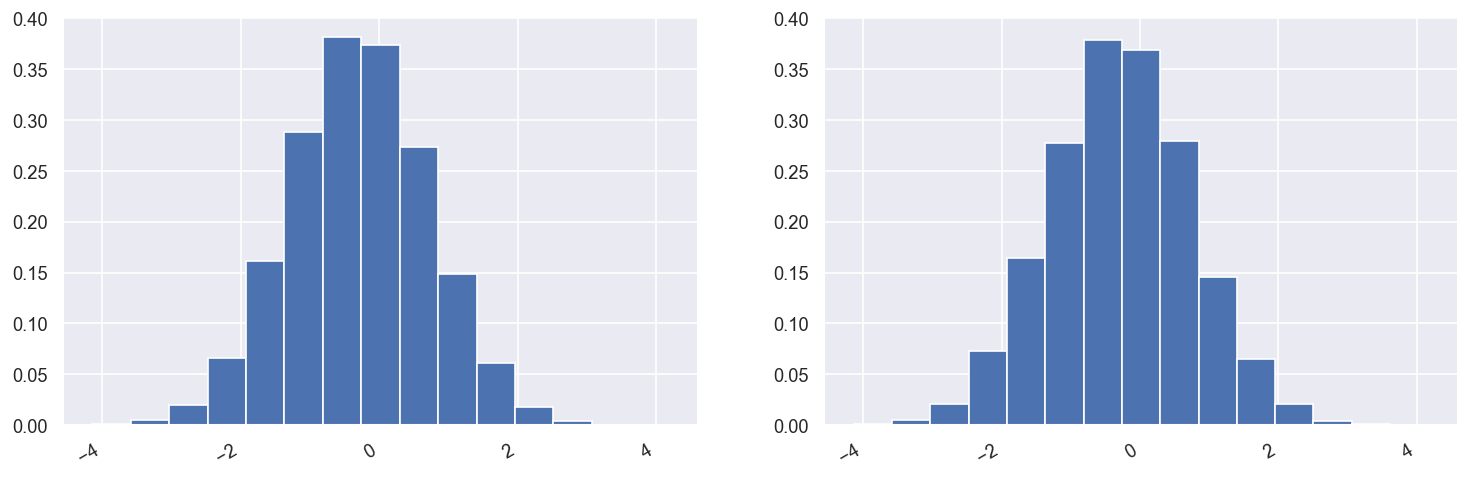

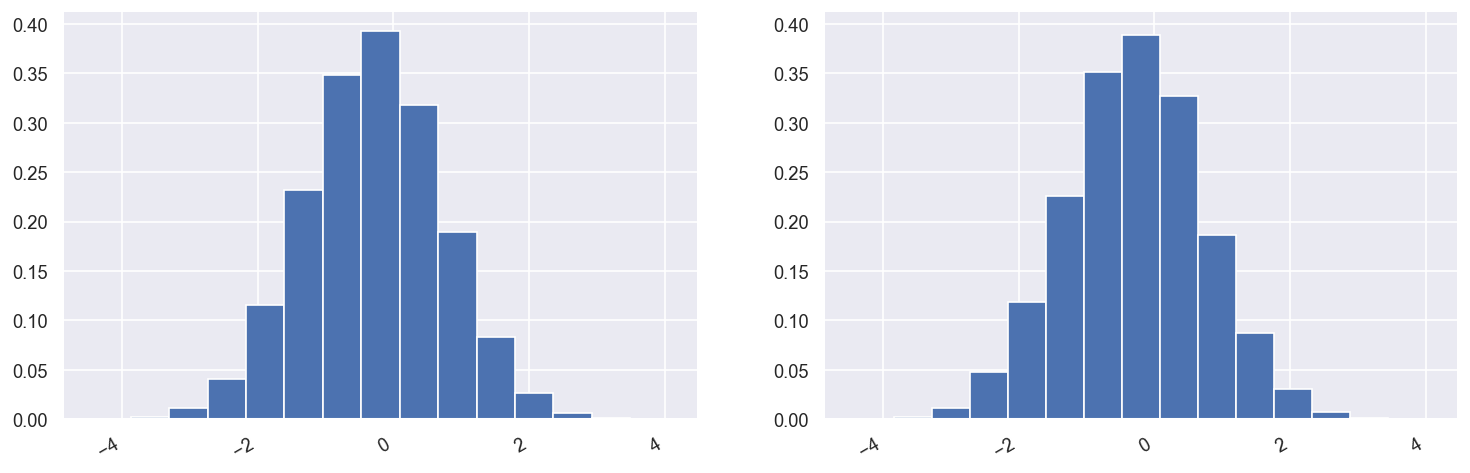

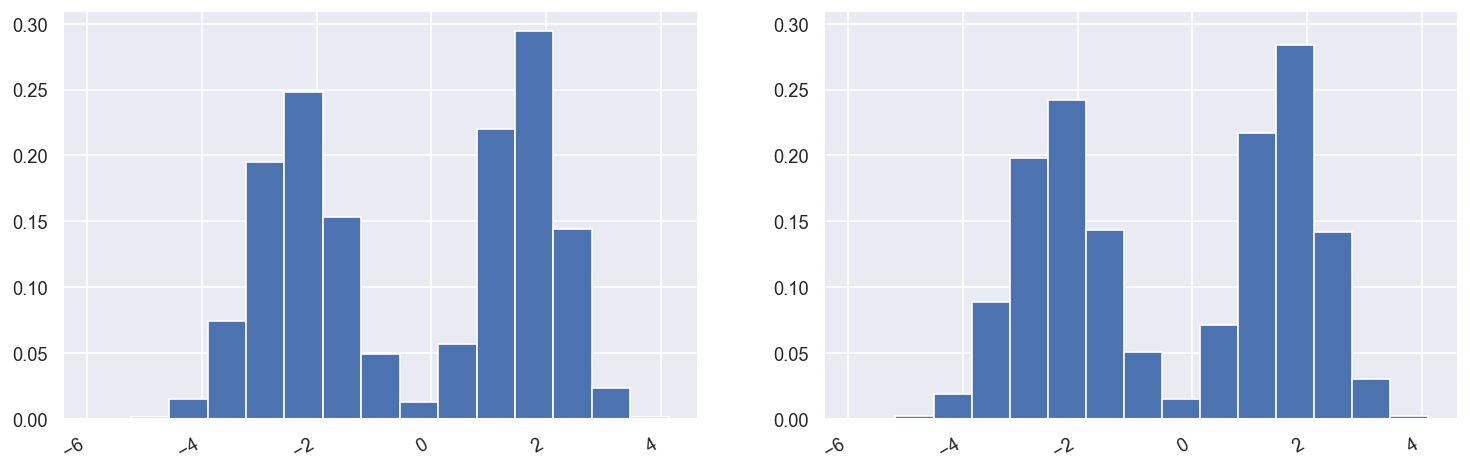

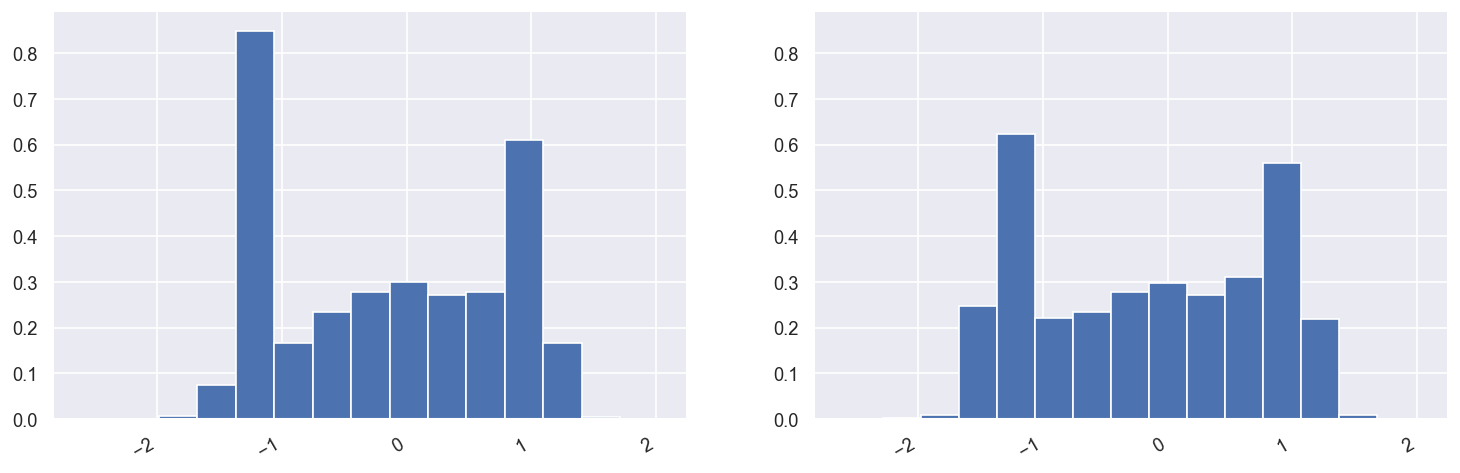

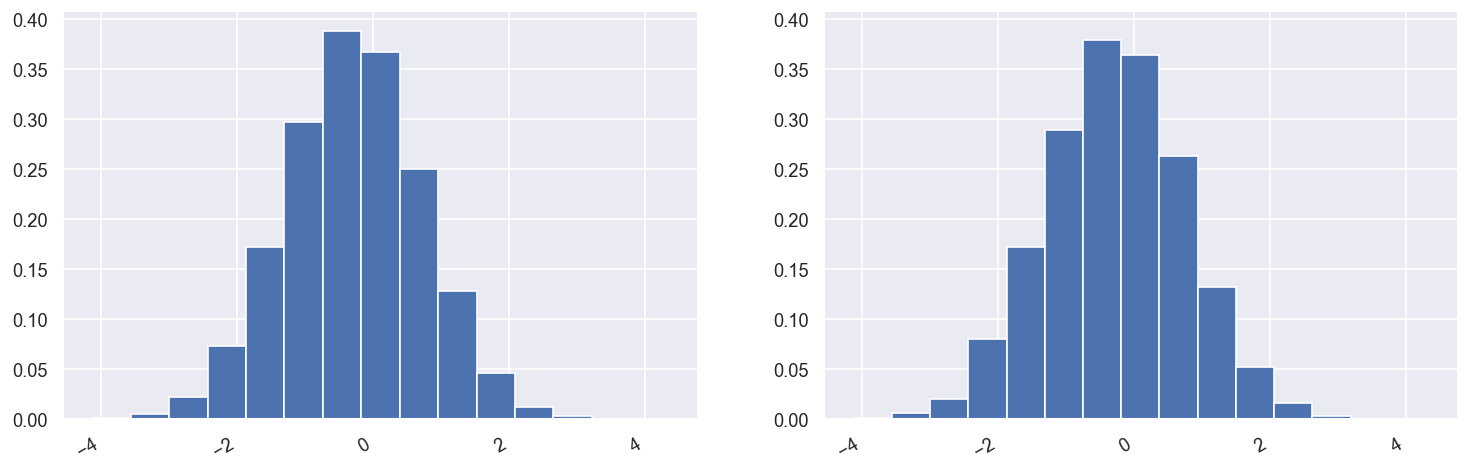

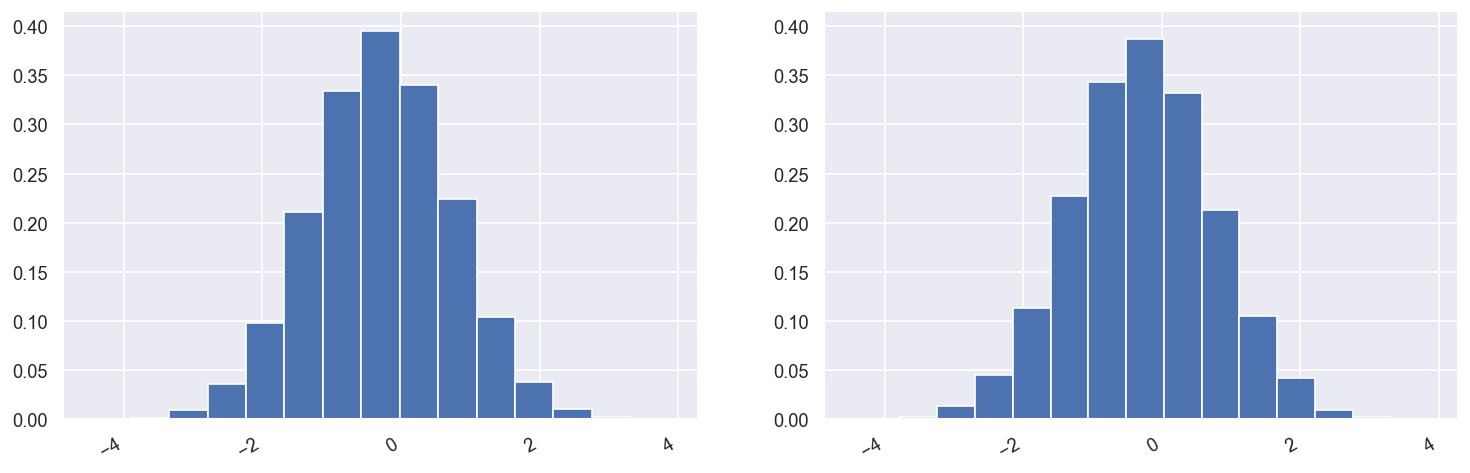

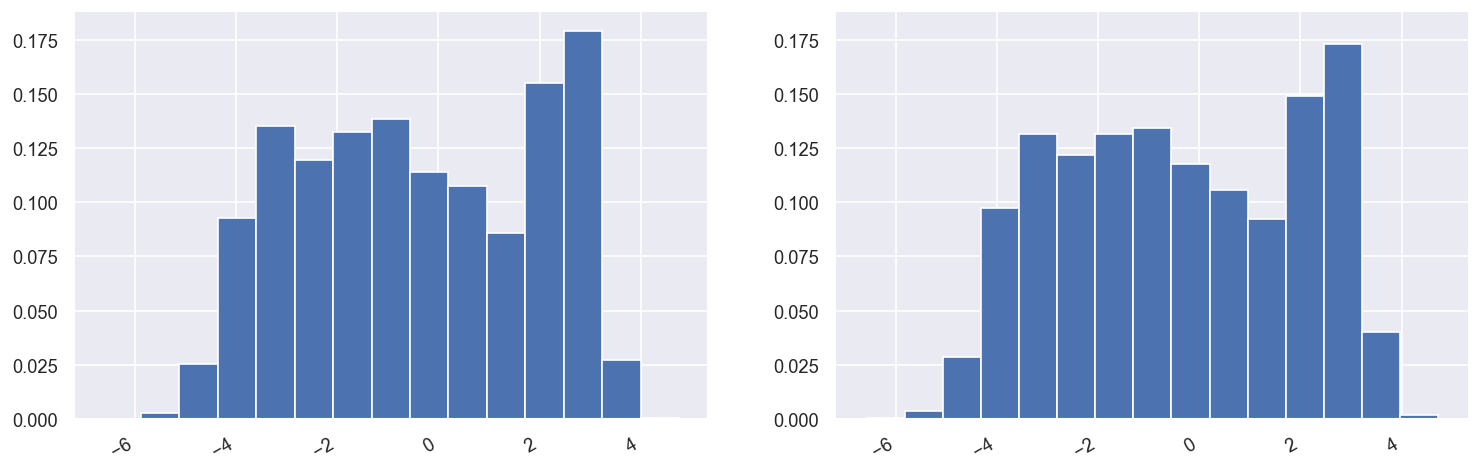

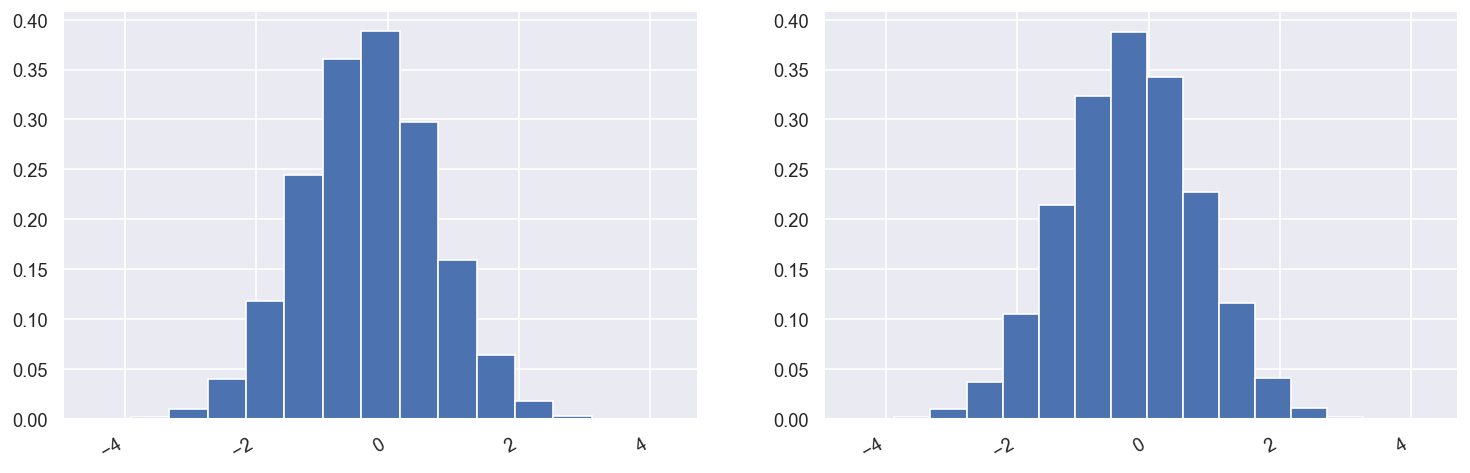

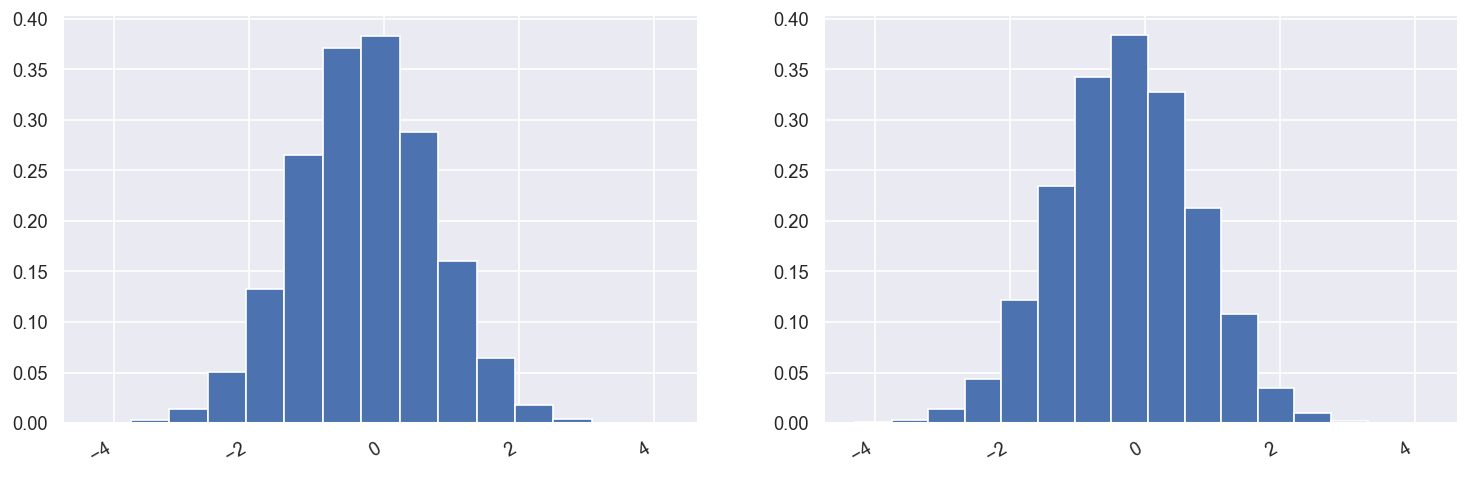

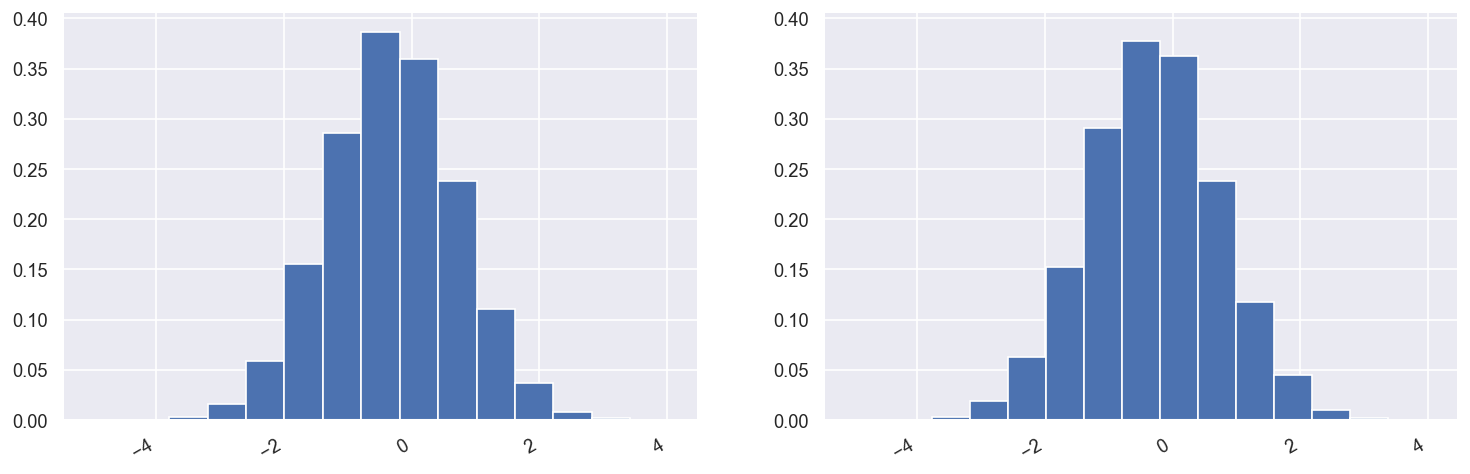

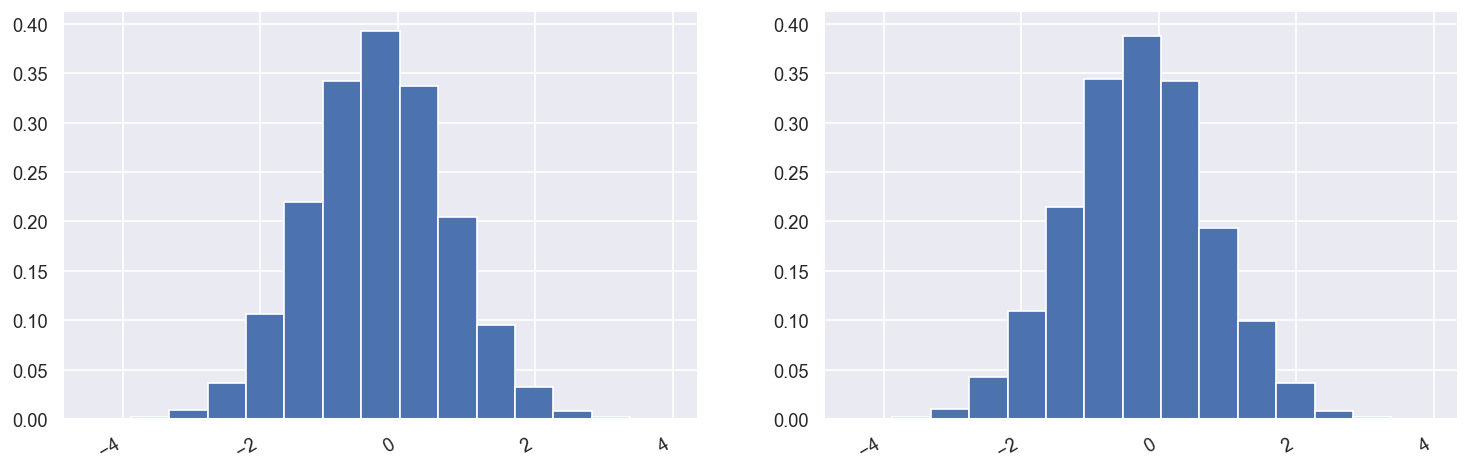

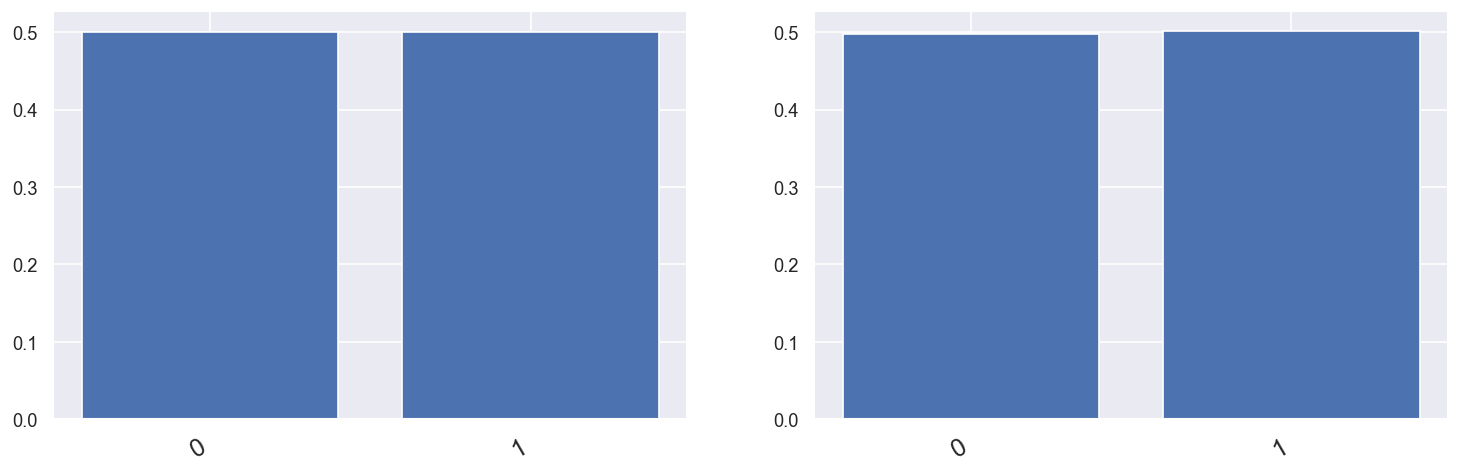

In [9]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

#### 5.3 compare pairwise mutual information

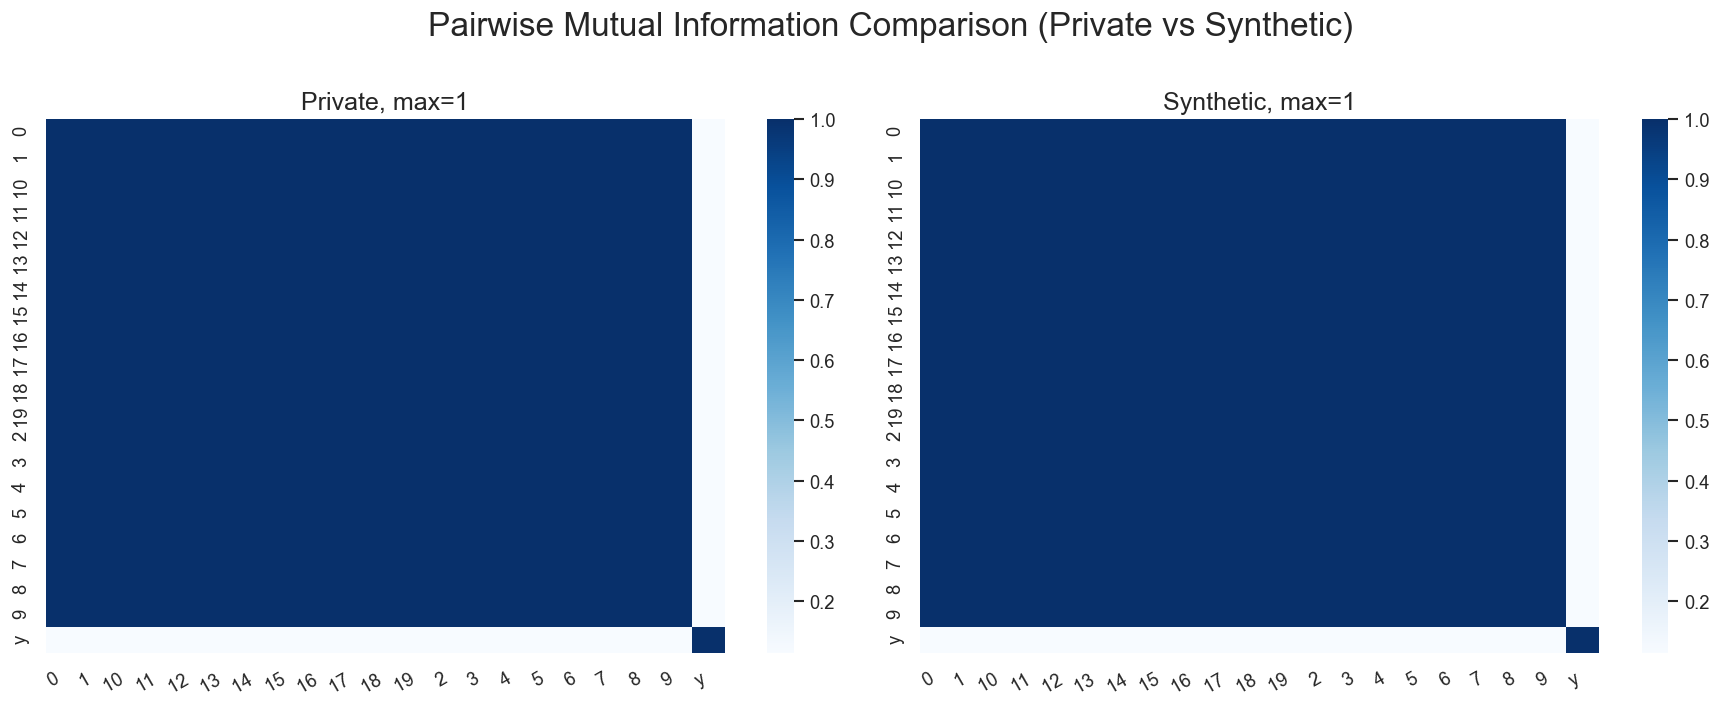

In [10]:
inspector.mutual_information_heatmap()